In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
print(tf.__version__)


2.9.2


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving final.zip to final.zip


In [ ]:
import zipfile
import io
zf = zipfile.ZipFile(io.BytesIO(uploaded['final.zip']), "r")
zf.extractall()

In [55]:
# Create a list with the filepaths for training and testing
train_dir = Path('../content/final/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('../content/final/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path('../content/final/validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

upload_dir = Path('../content/final/upload_images')
val_filepaths = list(upload_dir.glob(r'**/*.jpg'))

In [ ]:

def image_processing(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df


In [ ]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)


In [ ]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 270

Number of different labels: 4

Labels: ['banana' 'eggplant' 'apple' 'carrot']


In [ ]:
train_df.head(5)

,Filepath,Label
0,../content/final/train/banana/Image_63.jpg,banana
1,../content/final/train/banana/Image_57.jpg,banana
2,../content/final/train/eggplant/Image_67.jpg,eggplant
3,../content/final/train/apple/Image_34.jpg,apple
4,../content/final/train/apple/Image_61.jpg,apple


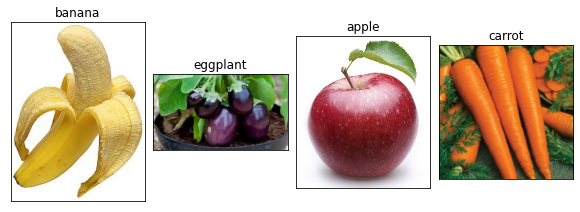

In [ ]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)


In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)


Found 270 validated image filenames belonging to 4 classes.


In [ ]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)


Found 35 validated image filenames belonging to 4 classes.


In [ ]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 35 validated image filenames belonging to 4 classes.


In [ ]:

pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)


Epoch 1/5
9/9 [==============================] - 16s 2s/step - loss: 0.5455 - accuracy: 0.8333 - val_loss: 0.2234 - val_accuracy: 0.9143
Epoch 2/5
9/9 [==============================] - 11s 1s/step - loss: 0.0458 - accuracy: 0.9926 - val_loss: 0.2454 - val_accuracy: 0.9143
Epoch 3/5
9/9 [==============================] - 11s 1s/step - loss: 0.0175 - accuracy: 0.9963 - val_loss: 0.3161 - val_accuracy: 0.8857


In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1


2/2 [==============================] - 2s 90ms/step


['banana',
 'eggplant',
 'apple',
 'eggplant',
 'eggplant',
 'banana',
 'apple',
 'carrot',
 'banana',
 'eggplant',
 'apple',
 'banana',
 'carrot',
 'carrot',
 'apple',
 'eggplant',
 'apple',
 'banana',
 'banana',
 'carrot',
 'carrot',
 'banana',
 'eggplant',
 'carrot',
 'apple',
 'eggplant',
 'carrot',
 'eggplant',
 'banana',
 'apple',
 'apple',
 'carrot',
 'carrot',
 'eggplant',
 'eggplant']

In [ ]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [ ]:
img = output('../content/final/test/carrot/Image_1.jpg')
img


1/1 [==============================] - 0s 20ms/step


'carrot'

In [ ]:
model.save('FV.h5')

**####Run streamlit app from a Google Colab Notebook###**

In [ ]:
!pip install -q streamlit

     |████████████████████████████████| 9.2 MB 7.2 MB/s 
     |████████████████████████████████| 237 kB 75.0 MB/s 
     |████████████████████████████████| 78 kB 8.8 MB/s 
     |████████████████████████████████| 182 kB 72.3 MB/s 
     |████████████████████████████████| 164 kB 76.1 MB/s 
     |████████████████████████████████| 4.7 MB 55.4 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
     |████████████████████████████████| 51 kB 7.7 MB/s 


In [59]:
%%writefile app.py

import streamlit as st
from PIL import Image
import requests
from bs4 import BeautifulSoup


labels = {0: 'apple', 1: 'banana', 2: 'beetroot', 3: 'bell pepper', 4: 'cabbage', 5: 'capsicum', 6: 'carrot',
          7: 'cauliflower', 8: 'chilli pepper', 9: 'corn', 10: 'cucumber', 11: 'eggplant', 12: 'garlic', 13: 'ginger',
          14: 'grapes', 15: 'jalepeno', 16: 'kiwi', 17: 'lemon', 18: 'lettuce',
          19: 'mango', 20: 'onion', 21: 'orange', 22: 'paprika', 23: 'pear', 24: 'peas', 25: 'pineapple',
          26: 'pomegranate', 27: 'potato', 28: 'raddish', 29: 'soy beans', 30: 'spinach', 31: 'sweetcorn',
          32: 'sweetpotato', 33: 'tomato', 34: 'turnip', 35: 'watermelon'}

fruits = ['Apple', 'Banana', 'Bello Pepper', 'Chilli Pepper', 'Grapes', 'Jalepeno', 'Kiwi', 'Lemon', 'Mango', 'Orange',
          'Paprika', 'Pear', 'Pineapple', 'Pomegranate', 'Watermelon']
vegetables = ['Beetroot', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Corn', 'Cucumber', 'Eggplant', 'Ginger',
              'Lettuce', 'Onion', 'Peas', 'Potato', 'Raddish', 'Soy Beans', 'Spinach', 'Sweetcorn', 'Sweetpotato',
              'Tomato', 'Turnip']


def fetch_calories(prediction):
    try:
        url = 'https://www.google.com/search?&q=calories in ' + prediction
        req = requests.get(url).text
        scrap = BeautifulSoup(req, 'html.parser')
        calories = scrap.find("div", class_="BNeawe iBp4i AP7Wnd").text
        return calories
    except Exception as e:
        st.error("Can't able to fetch the Calories")
        print(e)


def run():
    st.title("Food Image Detection")
    img_file = st.file_uploader("Choose an Image", type=["jpg", "png"])
    if img_file is not None:
        img = Image.open(img_file).resize((250, 250))
        st.image(img, use_column_width=False)
        save_image_path = './final/upload_images/' + img_file.name
        with open(save_image_path, "wb") as f:
            f.write(img_file.getbuffer())

        # if st.button("Predict"):
        if img_file is not None:
            # result = processed_img(save_image_path)
            url = 'http://192.168.1.5:5000/predict'
            form_data = {'file': open(save_image_path, 'rb')}
            resp = requests.post(url, files=form_data)
            resp_dict = resp.json()
            result = resp_dict['prediction']
            print(result)
            if result in vegetables:
                st.info('**Category : Vegetables**')
            else:
                st.info('**Category : Fruit**')
            st.success("**Predicted : " + result + '**')
            cal = fetch_calories(result)
            if cal:
                st.warning('**' + cal + '(100 grams)**')


run()

Overwriting app.py


In [36]:
# !pip uninstall -y Pillow
# # install the new one
# !pip install Pillow==5.3.0
# # import the new one
# import PIL
# print(PIL.PILLOW_VERSION)

In [37]:
# from keras_preprocessing.image import img_to_array

In [58]:
import streamlit as st
from PIL import Image
from keras_preprocessing.image import load_img, img_to_array
import numpy as np
from keras.models import load_model
import requests
from bs4 import BeautifulSoup

model = load_model('FV.h5')
labels = {0: 'apple', 1: 'banana', 2: 'beetroot', 3: 'bell pepper', 4: 'cabbage', 5: 'capsicum', 6: 'carrot',
          7: 'cauliflower', 8: 'chilli pepper', 9: 'corn', 10: 'cucumber', 11: 'eggplant', 12: 'garlic', 13: 'ginger',
          14: 'grapes', 15: 'jalepeno', 16: 'kiwi', 17: 'lemon', 18: 'lettuce',
          19: 'mango', 20: 'onion', 21: 'orange', 22: 'paprika', 23: 'pear', 24: 'peas', 25: 'pineapple',
          26: 'pomegranate', 27: 'potato', 28: 'raddish', 29: 'soy beans', 30: 'spinach', 31: 'sweetcorn',
          32: 'sweetpotato', 33: 'tomato', 34: 'turnip', 35: 'watermelon'}

fruits = ['Apple', 'Banana', 'Bello Pepper', 'Chilli Pepper', 'Grapes', 'Jalepeno', 'Kiwi', 'Lemon', 'Mango', 'Orange',
          'Paprika', 'Pear', 'Pineapple', 'Pomegranate', 'Watermelon']
vegetables = ['Beetroot', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Corn', 'Cucumber', 'Eggplant', 'Ginger',
              'Lettuce', 'Onion', 'Peas', 'Potato', 'Raddish', 'Soy Beans', 'Spinach', 'Sweetcorn', 'Sweetpotato',
              'Tomato', 'Turnip']


def fetch_calories(prediction):
    try:
        url = 'https://www.google.com/search?&q=calories in ' + prediction
        req = requests.get(url).text
        scrap = BeautifulSoup(req, 'html.parser')
        calories = scrap.find("div", class_="BNeawe iBp4i AP7Wnd").text
        return calories
    except Exception as e:
        st.error("Can't able to fetch the Calories")
        print(e)


def processed_img(img_path):
    img = load_img(img_path, target_size=(224, 224, 3))
    img = img_to_array(img)
    img = img / 255
    img = np.expand_dims(img, [0])
    answer = model.predict(img)
    y_class = answer.argmax(axis=-1)
    print(y_class)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    print(res)
    return res.capitalize()


def run():
    st.title("Food Image Detection")
    img_file = st.file_uploader("Choose an Image", type=["jpg", "png"])
    if img_file is not None:
        img = Image.open(img_file).resize((250, 250))
        st.image(img, use_column_width=False)
        save_image_path = './final/upload_images/' + img_file.name
        with open(save_image_path, "wb") as f:
            f.write(img_file.getbuffer())

        # if st.button("Predict"):
        if img_file is not None:
            result = processed_img(save_image_path)
            print(result)
            if result in vegetables:
                st.info('**Category : Vegetables**')
            else:
                st.info('**Category : Fruit**')
            st.success("**Predicted : " + result + '**')
            cal = fetch_calories(result)
            if cal:
                st.warning('**' + cal + '(100 grams)**')


run()

In [41]:
!npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
updated 1 package and audited 36 packages in 0.426s

3 packages are looking for funding
  run `npm fund` for details

found 0 vulnerabilities



In [60]:
!streamlit run /content/app.py &>/content/logs.txt &

In [61]:
!npx localtunnel --port 8501

npx: installed 22 in 1.646s
your url is: https://sad-pots-cough-34-83-179-101.loca.lt
^C
